In [15]:
import scipy.integrate
import math
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [29]:
#Modelo SEIR++:
# S -> Susceptibles
# E -> Expuestos
# I -> Infectados
# R -> Recuperados
# B -> Beta, Tasa de transmisión
# D -> sensación pública de riesgo

population = 12000000 #Aprox de la población
E0 = 3 # casos iniciales
infection_delay = 4 #aprocimación de cuantos días llevaban infectados los primeros casos antes de llegar

m_total = 3 #cantidad de medidas tomadas
m_days = [ 0 for i in range(m_total)]

# Días en los que se tomaron nuevas medidas por parte del gobierno.
m_days[0] = 18 #Días hasta las primeras medidas (especificamente cierre de vuelos internacionales)
m_days[1] = 23 #Días hasta la 2da medida mayor
m_days[2] = 60 #cuarentena total hipotética

daysTotal = 30 #Días analizados 
 
gamma = 1/7  #valor cambiante 
#gamma es la tasa de recuperación: 1/gamma será el período de tiempo medio (en días) de recuperación (pasa a ser no infector)
#es el tiempo medio que el paciente pasa estando infectado (en realidad es que pueda infectar a otros)

sigma = 1/5  #valor promedio relativamente fiel
# sigma es la velocidad con la que se transforma un expuesto en infector: 1/sigma es el período promedio de este cambio

r1 = 2.68 #Tasa básica de reproducción del COVID19 sin medidas tomadas, sería beta/gamma y algunas versiones del modelo usan r0 en vez de beta
# r es otro de los parámetros difíciles de estimar y que varía bastante
r0 = 8.4 #Valor máximo estimado con los resultados obtenidos en China
# en este caso tomamos r0 mucho mayor por causa de la cantidad de entradas de nuevos casos extranjeros y r1 será 2.68

beta0 = r0*gamma #Tasa de transmición inicial media sin medidas tomadas
beta1 = r1*gamma #Tasa de transmición luego del fin de los vuelos
#beta es la tasa de transmisión, 1/beta representa mayormente la probabilidad de contagio luego de un contacto Inf - Suscep
#beta es de los párametros más complicados de estimar por la existencia de asintomáticos y de los más importantes en el modelo

alfa = [0 for i in range(m_total)]
# fuerza de las medidas tomadas por el gobierno de 0 a 1 un valor que determina beta y es dificil de estimar
# esto se puede tomar como una función constante a trozos y graficar según los cambios en alfa
alfa[0] = 0.2 #rigor de las medidas iniciales
alfa[1] = 0.45 #segundas medidas
alfa[2] = 0.6 #cuarentena de 0.5 ~ 0.6? 
#alfa[2] = 0.65 #ESTO ES UN EJEMPLO DE MEDIDAS EFECTIVAS

k = 1117.3
#intensidad de la reacción de los individuos, valor calculado en China extremadamente alto

presympt_time = 5.2
#Tiempo medio en que demora la aparición de los sintomas, tiempo de incubación

noSymptoms = 0.012 
#porciento de personas asintomáticas

fRatio = 0.90 #De nuevo un valor optimista que depende del rigor de las medidas
#porciento de casos de infectados con síntomas detectados

findRatio = (1-noSymptoms) * fRatio
#porciento de casos de infectados detectados (se asume que todos son hospitalizados)

findTime = presympt_time + 3 # (Valor arbitrario)
#tiempo medio en días que se demora en hospitalizar a un paciente infectado

timeInHospital = 14 #tiempo que se mantiene un paciente infectado en el hospital
timeInfected = 1.0 / gamma #duración media de la infección

UCI_count = 200  
#cantidad de unidades de cuidados intensivos disponibles en el país

CriticalRate = 0.047
#porciento de pacientes que necesitan cuidados intensivos

critical_lag = 5 #(Valor arbitrario)
#tiempo medio en días que un paciente hospitalizado pasa a estado crítico

death_delay = 7 #(Valor arbitrario)
#tiempo medio en días que un paciente en estado crítico muere

UCIFatalityRate = 0.023 # (Calculado en China)
#porciento de pacientes que utilizan UCIs y mueren

FatalityRate = CriticalRate * 0.95 # (Valor arbitrario)
#porciento de pacientes críticos que mueren sin acceso a UCI

Hosp = [0 for i in range(daysTotal)]
#array con la cantidad de casos hospitalizados en un día dado

Critical = [0 for i in range(daysTotal)]
#array con la cantidad de casos críticos en un día dado     

first_case_date = dates.datetime.date(2020,3,6) #Fecha de llegada (no de detección) del primer caso registrado
 
    
###OPCIONES###    
plt_detail = 1  # Plotear con cuadrículas (1), plotear "normal" (0)
plt_options = (0,1,1,1,0) # 0 para ocultar, 1 mostrar : muertes, recuperados, expuestos, infectados, hospitalizados
plt_method = 0  # 0 para predeterminado, 1 para Euler, 2 para Runge-Kutta de orden 2, 3 para Runge-Kutta orden 4
h = 0.1 # valor de h usado en los métodos numéricos
##############

In [30]:
def GetParams():

    print("Elige entre la modelación por defecto(0) or personalizada(1)")
    op = int(input())
    
    print("Total de días a analizar: ")
    daysTotal = int(input())
    
    if op == 1:
        print("Población: ")
        _population = int(input())
    
        print("Cantidad de casos iniciales: ")
        _E0 = int(input())
    
        print("Fecha de llegada de los primeros casos (YYYY-MM-DD): ")
        print("Ejemplo: '2020-2-29'")
        y,m,d = input().split("-")
        _first_case_date = dates.datetime.date(int(y),int(m),int(d))
        
        print("Cantidad de UCIs (unidades de cuidados intensivos) :" )
        _UCI_count = int(input())
        
        print("Cantidad de medidas mayores tomadas por el gobierno: ")
        _m_total = int(input())
        _m_days = [0 for i in range(_m_total)]
        
        print("Ingresa el # del día (contando desde el caso inicial) de esas medidas, separados por un espacio: ")
        print("Ejemplo: '7 21 40'")
        md = input().split(" ")
        for i in range (0,_m_total) : _m_days[i] = int(md[i])
        
        print("Intruduce la severidad (0-10) de cada medida, separado por un espacio: ")
        print("Ejemplo: '1 2 7'")
        sev = input().split(" ")
        _alfa = [0 for i in range(_m_total)]
        for i in range (0,_m_total): alfa[i] = (int(sev[i])/10)  
            
        print("Valor inicial estimado de r0: ")
        r0 = float(input())
        _beta0 = r0*gamma
    
        return _population,_E0,_beta0,_first_case_date,_UCI_count,_m_total,_m_days,_alfa,daysTotal
    
    return population,E0,beta0,first_case_date,UCI_count,m_total,m_days,alfa,daysTotal

In [31]:
#Modelo por defecto

def model(seir, t, m_total, m_days, alfa, beta0):
     
    S,E,I,R = seir
    N = S + E + I + R
       
    def D(I,t):
        return CriticalRate*I

    def Beta (I,t,N):
        if t < m_days[0]:
            return beta0
        else:
            for i in range (1,m_total):
                if t < m_days[i]:  
                    return beta1 * (1-alfa[i-1])* np.power((1-D(I,t)/N),k)
        return beta1 * (1-alfa[m_total-1])* np.power((1-D(I,t)/N),k)
    
    beta = Beta(I,t,N)
        
    dS = -1 * beta * S * I / N 
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    return dS, dE, dI, dR

In [32]:
#Método de solución predeterminado:

def Solve (params):  #Predeterminado
    
    population, m_total,m_days,alfa,beta0,daysTotal,E0 = params  
    X = np.arange(daysTotal)
    params2 = m_total,m_days,alfa,beta0
    
    seir = population - E0, 0, E0, 0
    
    y_data_var = scipy.integrate.odeint(model, seir, X, params2)
    S, E, I, R = y_data_var.T
    
    return X, S, E, I, R

In [33]:
# Modelo version 2 para métodos numéricos

def D(I,t):
        return CriticalRate*I
    
def Beta (I,t,N):
        if t < m_days[0]:
            return beta0
        else:
            for i in range (1,m_total):
                if t < m_days[i]:  
                    return beta1 * (1-alfa[i-1])* np.power((1-D(I,t)/N),k)
        return beta1 * (1-alfa[m_total-1])* np.power((1-D(I,t)/N),k)
        
def dS(t, S, E, I, R):
    N = S+E+I+R
    return -1 * Beta(I,t,N) * S * I / N 

def dE(t, S, E, I, R):
    N = S+E+I+R
    return Beta(I,t,N) * S * I / N - sigma * E

def dI(t, S, E, I, R):
    return sigma * E - gamma * I

def dR(t, S, E, I, R):
    return gamma * I

In [34]:
#Métodos de solución numéricos

def Solve_Euler (params,h):  #Método de Euler
    
    population, m_total,m_days,alfa,beta0,daysTotal,E0 = params  
    X = np.arange(daysTotal)  
    S,E,I,R,t = population - E0, 0, E0, 0, 0

    steps = int (1/h)
    depth = daysTotal*steps
    
    S_ = np.arange(daysTotal)
    S_dat = [0 for i in range (depth)]
    E_ = np.arange(daysTotal)
    E_dat = [0 for i in range (depth)]
    I_ = np.arange(daysTotal)
    I_dat = [0 for i in range (depth)]
    R_ = np.arange(daysTotal)
    R_dat = [0 for i in range (depth)]

    for i in range(depth):
        
        F1 = dS(t, S, E, I, R)
        G1 = dE(t, S, E, I, R)
        H1 = dI(t, S, E, I, R)
        I1 = dR(t, S, E, I, R)
        
        if (i>0): t = i*h
            
        S_dat[i] = S + h * F1
        S = S_dat[i] 
        E_dat[i] = E + h * G1
        E = E_dat[i] 
        I_dat[i] = I + h * H1
        I = I_dat[i] 
        R_dat[i] = R + h * I1 
        R = R_dat[i]  
        
    for j in range (daysTotal):
        S_ [j] =  (S_dat[j*steps])
        E_ [j] =  (E_dat[j*steps])
        I_ [j] =  (I_dat[j*steps])
        R_ [j] =  (R_dat[j*steps])

    return X, S_, E_, I_, R_       
    
    
def Solve_Runge_Kutta_2 (params,h):  #Runge-Kutta de segundo orden
    
    population, m_total,m_days,alfa,beta0,daysTotal,E0 = params  
    X = np.arange(daysTotal)  
    S,E,I,R,t = population - E0, 0, E0, 0, 0

    steps = int (1/h)
    depth = daysTotal*steps
    
    S_ = np.arange(daysTotal)
    S_dat = [0 for i in range (depth)]
    E_ = np.arange(daysTotal)
    E_dat = [0 for i in range (depth)]
    I_ = np.arange(daysTotal)
    I_dat = [0 for i in range (depth)]
    R_ = np.arange(daysTotal)
    R_dat = [0 for i in range (depth)]

    for i in range(depth):
    
        F1 = dS(t, S, E, I, R)
        G1 = dE(t, S, E, I, R)
        H1 = dI(t, S, E, I, R)
        I1 = dR(t, S, E, I, R)
        
        if (i>0): t = i*h
    
        F2 = dS(t + h, S + h * F1, E + h * G1, I + h * H1, R + h * I1)
        G2 = dE(t + h, S + h * F1, E + h * G1, I + h * H1, R + h * I1)
        H2 = dI(t + h, S + h * F1, E + h * G1, I + h * H1, R + h * I1)
        I2 = dR(t + h, S + h * F1, E + h * G1, I + h * H1, R + h * I1)
    
        S_dat[i] = (S + (h / 2) * (F1 + F2))
        S = S_dat[i] 
        E_dat[i] = (E + (h / 2) * (G1 + G2))
        E = E_dat[i] 
        I_dat[i] = (I + (h / 2) * (H1 + H2))
        I = I_dat[i] 
        R_dat[i] = (R + (h / 2) * (I1 + I2))
        R = R_dat[i]  
    
    for j in range (daysTotal):
        S_ [j] =  (S_dat[j*steps])
        E_ [j] =  (E_dat[j*steps])
        I_ [j] =  (I_dat[j*steps])
        R_ [j] =  (R_dat[j*steps])

    return X, S_, E_, I_, R_


def Solve_Runge_Kutta_4 (params,h): #Runge Kutta de cuarto orden
    
    population, m_total,m_days,alfa,beta0,daysTotal,E0 = params  
    X = np.arange(daysTotal)
    S,E,I,R,t = population - E0, 0, E0, 0, 0
       
    steps = int (1/h)
    depth = daysTotal*steps
    
    S_ = np.arange(daysTotal)
    S_dat = [0 for i in range (depth)]
    E_ = np.arange(daysTotal)
    E_dat = [0 for i in range (depth)]
    I_ = np.arange(daysTotal)
    I_dat = [0 for i in range (depth)]
    R_ = np.arange(daysTotal)
    R_dat = [0 for i in range (depth)]

    for i in range(depth):
    
        F1 = dS(t, S, E, I, R)
        G1 = dE(t, S, E, I, R)
        H1 = dI(t, S, E, I, R)
        I1 = dR(t, S, E, I, R)
        
        if (i>0):
            t = i*h
        
        F2 = dS(t + h / 2, S + h * F1 / 2, E + h * G1 / 2 , I + h * H1 / 2, R + h * I1 / 2)
        G2 = dE(t + h / 2, S + h * F1 / 2, E + h * G1 / 2 , I + h * H1 / 2, R + h * I1 / 2)
        H2 = dI(t + h / 2, S + h * F1 / 2, E + h * G1 / 2 , I + h * H1 / 2, R + h * I1 / 2)
        I2 = dR(t + h / 2, S + h * F1 / 2, E + h * G1 / 2 , I + h * H1 / 2, R + h * I1 / 2)
    
        F3 = dS(t + h / 2, S + h * F2 / 2, E + h * G2 / 2, I + h * H2 / 2, R + h * I2 / 2)
        G3 = dE(t + h / 2, S + h * F2 / 2, E + h * G2 / 2, I + h * H2 / 2, R + h * I2 / 2)
        H3 = dI(t + h / 2, S + h * F2 / 2, E + h * G2 / 2, I + h * H2 / 2, R + h * I2 / 2)
        I3 = dR(t + h / 2, S + h * F2 / 2, E + h * G2 / 2, I + h * H2 / 2, R + h * I2 / 2)
    
        F4 = dS(t + h, S + h * F3, E + h * G3, I + h * H3, R + h * I3)
        G4 = dE(t + h, S + h * F3, E + h * G3, I + h * H3, R + h * I3)
        H4 = dI(t + h, S + h * F3, E + h * G3, I + h * H3, R + h * I3)
        I4 = dR(t + h, S + h * F3, E + h * G3, I + h * H3, R + h * I3)
    
        S_dat[i] = (S + (h / 6) * (F1 + 2 * F2 + 2 * F3 + F4))
        S = S_dat[i] 
        E_dat[i] = (E + (h / 6) * (G1 + 2 * G2 + 2 * G3 + G4))
        E = E_dat[i] 
        I_dat[i] = (I + (h / 6) * (H1 + 2 * H2 + 2 * H3 + H4))
        I = I_dat[i] 
        R_dat[i] = (R + (h / 6) * (I1 + 2 * I2 + 2 * I3 + I4))
        R = R_dat[i] 
    
    for j in range (daysTotal):
        S_ [j] =  (S_dat[j*steps])
        E_ [j] =  (E_dat[j*steps])
        I_ [j] =  (I_dat[j*steps])
        R_ [j] =  (R_dat[j*steps])

    return X, S_, E_, I_, R_

In [35]:
#Calendario simplificado

def calc_date(date0,days_passed):
    x = date0.toordinal() + days_passed  
    ans = date0.fromordinal(x)
    return ans    

In [36]:
#Resolviendo y usando el modelo:

def BuildSolution (params):
    
    population,E0,beta0,first_case_date,UCI_count,m_total,m_days,alfa,daysTotal = params
    
    params2 = population,m_total,m_days,alfa,beta0,daysTotal,E0
    
    X, S, E, I, R = Solve(params2) # DEFAULT
    
    if (plt_method == 1):
        X, S, E, I, R = Solve_Euler(params2,h)       
    if (plt_method == 2):
        X, S, E, I, R = Solve_Runge_Kutta_2(params2,h)
    if (plt_method == 3):
        X, S, E, I, R = Solve_Runge_Kutta_4(params2,h)
    
    death_count = 0 #cantidad de muertes
    hosp_total = 0 #cantidad total de hospitalizados
    rec_total = 0 #total de recuperados
    firstfoundcase = 0   #día del primer caso hospitalizado

    deaths = [0 for i in range (0,daysTotal)]  #muertes diarias
    Dprev = 0
    deaths = [0 for i in range (0,daysTotal)] 
    Rprev = 0
    lag = int(findTime)+1
    clag = lag + critical_lag
    dlag = death_delay
    
    #Calcula la cantidad de hospitalizados, críticos y las muertes diarias
    #Los hospitalizados y críticos forman parte del número de infectados y las muertes de los "recuperados"
    
    Hosp = [0 for i in range(daysTotal)]
    #array con la cantidad de casos hospitalizados en un día dado
    Critical = [0 for i in range(daysTotal)]
    #array con la cantidad de casos críticos en un día dado     
    
    for i in range (lag,daysTotal):
        Hosp[i] = I[i-lag] * findRatio
        hosp_total +=  Hosp[i]   
        if (firstfoundcase == 0 and i > 2 and hosp_total > 0):
            firstfoundcase = i
        Critical[i] = I[i-clag] * CriticalRate
        needed_UCI = Critical[i-clag] - UCI_count #diferencia entre las UCIs actuales y las necesitadas
        if (needed_UCI > 0):
            precalc_FR = (UCIFatalityRate) * (UCI_count/Critical[i-clag]) + (FatalityRate) * (needed_UCI/Critical[i-clag])      
        FR = UCIFatalityRate if Critical[i-clag] <= UCI_count else precalc_FR
    
        if i + dlag < daysTotal:
            deaths[i+dlag] = FR * (R[i] - Rprev)
            death_count += deaths[i+dlag]
            Rprev = R[i]
            Dprev = deaths[i+dlag]  
        
    if firstfoundcase > infection_delay : firstfoundcase -= infection_delay 
    # La idea de esto es que el primer caso ya estaba contagiado cuando arribo, se aproxima cuanto tiempo 
    
    return X,S,E,I,R,death_count, hosp_total, rec_total, first_case_date, firstfoundcase,Hosp,daysTotal

In [37]:
def BuildStadistics(data):
    
    X,S,E,I,R,death_count, hosp_total, rec_total, first_case_date, firstfoundcase,Hosp, daysTotal = data
    
    infected = E[0]    #total de infectados 
    worstday = 0      #día con más infectados
    maxinfects = 0    #máximo número de infectados
    maxexposure = 0   #máximo número de población expuesta a la enfermedad (posibles contagios)
    maxexposure_day = 0  #día de mayor exposición al contagio 
    
    for i in range (0,daysTotal):
        if I[i] > maxinfects:
            worstday = i
            maxinfects = I[i]
        if R[i] > infected: infected = R[i]
        if E[i] > maxexposure:
            maxexposure_day = i
            maxexposure = E[i]
    infected = infected + I [daysTotal-1]
    
    return X,S,E,I,R,infected,worstday,maxinfects,maxexposure,maxexposure_day,death_count,hosp_total,rec_total,firstfoundcase,first_case_date,Hosp,daysTotal

In [38]:
def PlotSolution(data):
    
    X,S,E,I,R,infected,worstday,maxinfects,maxexposure,maxexposure_day,death_count,hosp_total,rec_total,firstfoundcase,first_case_date,Hosp,daysTotal = data
    
    fig = plt.figure(dpi=100, figsize=(16,9))
    ax = fig.add_subplot(111)

    if plt_options[0]==1:
        ax.plot(X, deaths, 'black', alpha=0.72, lw=2, label='Muertes(t)')  #muy pequeño en relación a los otros
    if plt_options[1]==1:
        ax.plot(X, R, 'g', alpha=0.72, lw=2, label='Recuperados(t)')       #muy grande en relación a los otros 
    if plt_options[2]==1:
        ax.plot(X, E, 'y', alpha=0.72, lw=2, label='Expuestos (t)')
    if plt_options[3]==1:
        ax.plot(X, I, 'r', alpha=0.72, lw=2, label='Infectados (t)')
    if plt_options[4]==1:
        ax.plot(X, Hosp, 'b', alpha=0.72, lw=2, label='Hospitalizados (t)')
        
    ax.set_xlabel('Tiempo en días')
    ax.set_ylabel('Cantidad de Personas')
    ax.set_ylim(bottom=1.0)
    
    if plt_detail == 1 :
        ax.grid(ls='-')
    else:
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')

    plt.legend(loc='best')   
    plt.show()

In [39]:
def AditionalInfo(data):
    
    X,S,E,I,R,infected,worstday,maxinfects,maxexposure,maxexposure_day,death_count,hosp_total,rec_total,firstfoundcase,first_case_date, Hosp,daysTotal = data
    
    inf = int(infected)
    dt = daysTotal - 1
    day0 = first_case_date
    maxinfects = int(maxinfects)  
    maxexposure = int(maxexposure) 
    death_count = int(death_count)
     
    print("Total de infectados: ", inf,"(",(inf/population*100),"% de la población)")
    print("Muertes: ", death_count, "(",(death_count/population*100),"% de la población)")
    print("Pico de infección:", calc_date(day0,worstday),"con un total de", int(I[worstday]), "infectados")
    print("Día de mayor exposición al virus:", calc_date(day0,maxexposure_day),"con un total de", maxexposure, "expuestos")
    print("Pacientes infectados hospitalizados:",int(Hosp[dt]), "(",(Hosp[dt]/I[dt]*100),"% de los infectados actuales)")
    print("Primera hospitalización el:", calc_date(day0,firstfoundcase))
    print("Cantidad de pacientes recuperados:", int(R[dt]))

In [40]:
def Init(): 
    params = GetParams()
    solution = BuildSolution(params)
    data = BuildStadistics(solution)
    PlotSolution(data)   
    AditionalInfo(data)

Elige entre la modelación por defecto(0) or personalizada(1)
0
Total de días a analizar: 
60


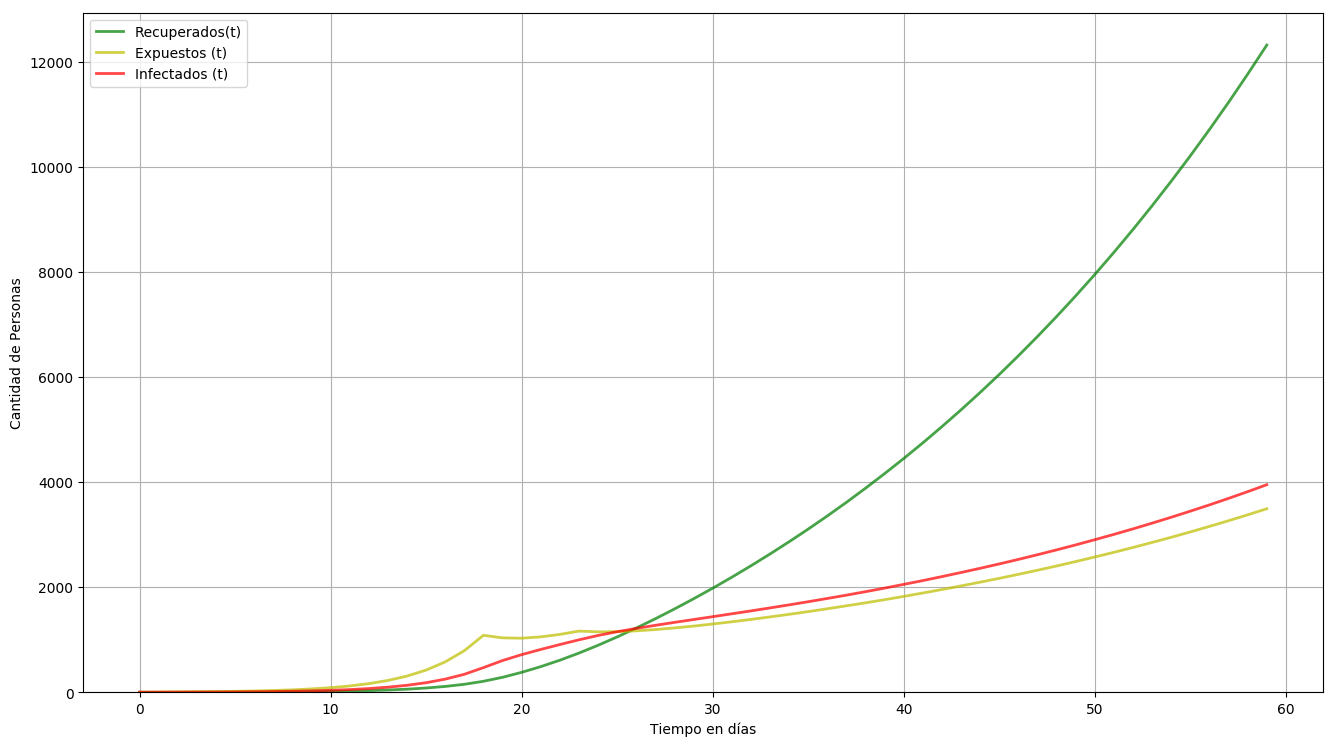

Total de infectados:  16262 ( 0.13551666666666667 % de la población)
Muertes:  202 ( 0.0016833333333333333 % de la población)
Pico de infección: 2020-05-04 con un total de 3949 infectados
Día de mayor exposición al virus: 2020-05-04 con un total de 3492 expuestos
Pacientes infectados hospitalizados: 2581 ( 65.3671207901 % de los infectados actuales)
Primera hospitalización el: 2020-03-11
Cantidad de pacientes recuperados: 12313


In [41]:
Init()